## Pembuka 

Blog ini akan membahas teknik sederhana untuk *keyword extraction* atau ekstraksi kata kunci dari dokumen teks. 
Salah satu aplikasi dari *keyword extraction* bisa anda lihat di bagian bawah dari 
berita [detik.com](detik.com). Di setiap artikel dari detik.com tertulis keyword-keyword
yang diambil dari teks berita. Gambar dibawah merupakan contoh yang diambil dari artikel [ini](https://oto.detik.com/mobil/d-4748247/resmi-ini-tampang-toyota-yaris-terbaru-bisa-parkir-sendiri).

![keyword yang muncul di detik.com](keyword-detik-resize.jpg)

Dari contoh diatas bisa kita lihat bahwa *keyword* atau kata kunci yang diekstrak dari teks berita detik diatas bisa menjadi *rangkuman* isi dari berita. Kita bisa simpulkan bahwa artikel diatas merupakan artikel otomotif dengan bahasan tentang toyota yaris tanpa perlu membaca seluruh isi teks. Hal ini menjadi salah satu kegunaan utama dari aplikasi *keyword extraction*.

Nah, di blog ini saya akan coba membahas satu teknik ekstraksi kata kunci atau *keyword extraction* bahasa Indonesia dari dokumen teks. Idenya sederhana: kita hanya memperhitungkan kata kunci yang berjenis *kata benda* atau *frasa benda*. Dari daftar kata/frasa benda yang kita dapatkan, kita ambil beberapa kata/frasa benda yang *penting* saja, karena dari sebuah dokumen sangat mungkin kita mendapatkan ratusan kata/frasa benda, dan tidak mungkin kita mengambil semua kata/frasa benda tersebut menjadi kata kunci. 
Dari sini kita bisa tarik dua pertanyaan besar:

* Bagaimana cara kita mengambil kata/frasa benda dari teks?
* Bagaimana kita mengukur kepentingan dari sebuah kata/frasa benda?

Dua pertanyaan diatas yang akan menjadi topik utama di blog ini.

Implementasi teknik *keyword extraction* ini saya buat menggunakan Python dalam format Jupyter notebook.
Notebook tersebut dapat anda temukan di repo [github](https://github.com/bagasabisena/keyword-extraction) saya.

## Implementasi

Anda memerlukan *library* python `jupyter`, `stanfordnlp`, dan `nltk` untuk menjalankan proyek ini.
Semua bisa anda *install* menggunakan pip

```
pip install jupyter
pip install stanfordnlp
pip install nltk
```

sebelum kita mulai, kita perlu mengunduh *file* model bahasa Indonesia yang diperlukan untuk menjalankan fungsi stanfordnlp. Buka terminal di komputer anda dan jalankan perintah berikut

```
python -c "import stanfordnlp;stanfordnlp.download('id')"
```

Selain itu, kita juga membutuhkan korpus `stopwords` dari NLTK

```
python -m nltk.downloader stopwords
```

Sekarang kita bisa mulai dengan mengimpor *module* yang diperlukan

In [125]:
import string
from urllib.request import urlopen
import warnings


import stanfordnlp
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from collections import Counter
from IPython.display import display

warnings.filterwarnings('ignore')

### Ekstraksi Frasa Benda / Noun Phrase 

Berikutnya kita inisialisasi *pipeline* dari stanford NLP.
`stanfordnlp` menjalankan fungsi *tokenizer* baik *tokenizer* kalimat maupun kata, dan juga melakukan *POS tagging*.
*POS tagging* sangat penting karena seperti yang sudah dipaparkan di atas, kita hanya memperhitungkan
frasa benda sebagai kandidat *keyword*.

Omong-omong, `stanfordnlp` disini adalah library baru berbasis Python yang menggunakan *deep learning* sebagai model, berbeda dengan library serupa dari Stanford bernama `CoreNLP` yang berbasis Java.
Lumayan, disini kita jadi bisa mencoba library baru ini. Tidak semua fungsi-fungsi `CoreNLP` ada di `stanfordnlp`, namun pengembang tetap memberikan *interface* untuk bisa mengakses komponen `CoreNLP` melalui `stanfordnlp`.

In [93]:
nlp = stanfordnlp.Pipeline(lang='id', processors='tokenize,pos')

Use device: cpu
---
Loading: tokenize
With settings: 
{'model_path': '/Users/bagas/stanfordnlp_resources/id_gsd_models/id_gsd_tokenizer.pt', 'lang': 'id', 'shorthand': 'id_gsd', 'mode': 'predict'}
---
Loading: pos
With settings: 
{'model_path': '/Users/bagas/stanfordnlp_resources/id_gsd_models/id_gsd_tagger.pt', 'pretrain_path': '/Users/bagas/stanfordnlp_resources/id_gsd_models/id_gsd.pretrain.pt', 'lang': 'id', 'shorthand': 'id_gsd', 'mode': 'predict'}
Done loading processors!
---


Mari kita tes `stanfordnlp` menggunakan paragraf sederhana dengan dua kalimat di bawah

In [97]:
s = """
    Pemberi kerja adalah orang perseorangan, pengusaha, badan hukum, atau badan-badan lainnya yang 
    mempekerjakan tenaga kerja dengan membayar upah atau imbalan dalam bentuk lain.
    Pengusaha adalah orang perseorangan, persekutuan, atau badan hukum 
    yang menjalankan suatu perusahaan milik sendiri.
"""

Kita masukkan text tersebut ke *pipeline* yang sudah kita buat

In [98]:
doc = nlp(s.lower())
doc

Disini text yang dimasukkan menjadi object `Document`,
dan tiap kalimat di dalam dokumen sudah dipecah menggunakan *sentence tokenizer*
yang bisa diakses melalui atribut `sentences` yang merupakan `list` yang mana tiap elemennya adalah object `Sentence`.

In [99]:
doc.sentences

*Word tokenizer* dari pipeline bekerja memecah kalimat menjadi kumpulan kata, yang bisa diakses melalui atribut `words` yang merupakan `list`, dimana tiap elemennya adalah object `Word`.

In [101]:
doc.sentences[1].words

[<Word index=1;text=pengusaha;upos=NOUN;xpos=NSD;feats=Number=Sing>,
 <Word index=2;text=adalah;upos=AUX;xpos=O--;feats=_>,
 <Word index=3;text=orang;upos=NOUN;xpos=NSD;feats=Number=Sing>,
 <Word index=4;text=perseorangan;upos=NOUN;xpos=NSD;feats=Number=Sing>,
 <Word index=5;text=,;upos=PUNCT;xpos=Z--;feats=_>,
 <Word index=6;text=persekutuan;upos=NOUN;xpos=NSD;feats=Number=Sing>,
 <Word index=7;text=,;upos=PUNCT;xpos=Z--;feats=_>,
 <Word index=8;text=atau;upos=CCONJ;xpos=H--;feats=_>,
 <Word index=9;text=badan;upos=NOUN;xpos=NSD;feats=Number=Sing>,
 <Word index=10;text=hukum;upos=NOUN;xpos=VSA;feats=Number=Sing|Voice=Act>,
 <Word index=11;text=yang;upos=PRON;xpos=S--;feats=PronType=Rel>,
 <Word index=12;text=menjalankan;upos=VERB;xpos=VSA;feats=Number=Sing|Voice=Act>,
 <Word index=13;text=suatu;upos=DET;xpos=B--;feats=PronType=Ind>,
 <Word index=14;text=perusahaan;upos=NOUN;xpos=NSD;feats=Number=Sing>,
 <Word index=15;text=milik;upos=NOUN;xpos=VSA;feats=Number=Sing|Voice=Act>,
 <Word 

Selain memecah menjadi token kata, pipeline juga otomatis memberikan POS di tiap token-tokennya.
Sangat praktis.

In [103]:
for word in doc.sentences[1].words:
    print(word.text, word.upos)

pengusaha NOUN
adalah AUX
orang NOUN
perseorangan NOUN
, PUNCT
persekutuan NOUN
, PUNCT
atau CCONJ
badan NOUN
hukum NOUN
yang PRON
menjalankan VERB
suatu DET
perusahaan NOUN
milik NOUN
sendiri ADJ
. PUNCT


Tahap berikutnya adalah bagaimana kita memilih frasa-frasa yang bisa dianggap sebagai *keywords*.
Pada kalimat contoh diatas, terdapat 14 kata. Artinya terdapat 14 kandidat *keyword*.
Belum lagi kalau kita juga mempertimbangkan bigram sebagai kandidat *keyword*.

In [116]:
words = [word.text for word in doc.sentences[1].words]
bigrams = [
    bigram for bigram in list(ngrams(words, 2))
    if bigram[0] not in string.punctuation and bigram[1] not in string.punctuation
]
bigrams

[('pengusaha', 'adalah'),
 ('adalah', 'orang'),
 ('orang', 'perseorangan'),
 ('atau', 'badan'),
 ('badan', 'hukum'),
 ('hukum', 'yang'),
 ('yang', 'menjalankan'),
 ('menjalankan', 'suatu'),
 ('suatu', 'perusahaan'),
 ('perusahaan', 'milik'),
 ('milik', 'sendiri')]

Kalimat diatas memiliki 11 bigram, sehingga untuk kalimat tersebut terdapat 35 kandidat yang bisa diperhitungkan sebagai *keyword*. Kalau satu kalimat saja ada 35 kandidat *keyword*, bagaimana dengan satu dokumen teks?
Tentunya kita tidak bisa memilih satu-persatu bukan?
Untuk memperkecil himpunan (*set*) *keywords* yang bisa dipilih, kita menggunakan aturan/*rule* sederhana:

> Hanya frasa benda yang diperhitungkan sebagai kandidat *keyword*.

Frasa benda adalah frasa yang terdiri dari kata benda secara berurutan dan diikuti oleh kata sifat yang opsional.
Disini POS tagger berguna, karena POS tagger lah yang memberikan kelas kata ke setiap token dari sebuah kalimat.

Mengekstrak frasa benda adalah tugas dari *parser*. Untuk melakukan itu, saya bisa membuat parser kita sendiri, atau menggunakan parser bawaan yang disediakan oleh *library* `nltk`. Saya memilih untuk melakukan yang terakhir. Saya menggunakan `RegexpParser` dan membangun *grammar* sendiri untuk parser menggunakan aturan *regex*. 
Grammarnya begini:

NP (noun phrase atau frasa benda) = NOUN/PROPN+ ADJ*

Atau jika dijabarkan maka frasa benda (NP) dibangun dari satu atau lebih kata benda (NOUN/PROPN), diikuti oleh nol atau lebih ADJ.

Berikut adalah implementasi *parser* menggunakan NLTK

In [117]:
grammar = "NP: {<NOUN|PROPN>+ <ADJ>*}"
parser = nltk.RegexpParser(grammar)

dan berikut adalah hasil *parsing* dari *parser* yang kita buat sebelumnya

In [121]:
word_pos_pairs = [(word.text, word.upos) for word in doc.sentences[0].words]
tree = parser.parse(word_pos_pairs)
print(tree)

(S
  (NP pemberi/NOUN kerja/NOUN)
  adalah/AUX
  (NP orang/NOUN perseorangan/NOUN)
  ,/PUNCT
  (NP pengusaha/NOUN)
  ,/PUNCT
  (NP badan/NOUN hukum/NOUN)
  ,/PUNCT
  atau/CCONJ
  (NP badan-badan/NOUN lainnya/ADJ)
  yang/PRON
  mempekerjakan/VERB
  (NP tenaga/NOUN kerja/NOUN)
  dengan/ADP
  membayar/VERB
  (NP upah/NOUN)
  atau/CCONJ
  (NP imbalan/NOUN)
  dalam/ADP
  (NP bentuk/NOUN lain/ADJ)
  ./PUNCT)


Atau jika diilustrasikan dengan gambar

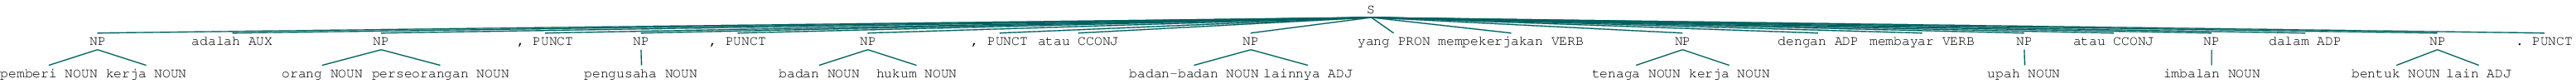

In [122]:
display(tree)

Kode berikut mengambil semua frasa NP dari hasil parsing yang berbentuk *tree*

In [123]:
keywords = []
for subtree in tree.subtrees():
    if subtree.label() == 'NP' and len(subtree.leaves()) >= 1:
        words = [item[0] for item in subtree.leaves()]
        keywords.append(' '.join(words))
            
keywords

['pemberi kerja',
 'orang perseorangan',
 'pengusaha',
 'badan hukum',
 'badan-badan lainnya',
 'tenaga kerja',
 'upah',
 'imbalan',
 'bentuk lain']

Disini terlihat bahwa *pemberi kerja*, *orang perseorangan*, *pengusaha*, *badan-badan lainnya*, *tenaga kerja*, *upah*, *imbalan*, *bentuk lain* merupakan frasa benda. Kita bisa mengurangi kandidat *keyword* dari 35 menjadi 9 dengan hanya memperhitungkan frasa benda.

### Contoh Ekstraksi Frasa Benda di Dokumen Nyata 

Kita akan praktekkan teknik ekstraksi di bagian sebelumnya ke dokumen nyata. Saya akan menggunakan dokumen
undang-undang nomor 13 tahun 2003 sebagai contoh. Dokumen ini terdiri dari 20 ribu kata.

Lalu kenapa saya memilih undang-undang sebagai contoh? Karena dokumen undang-undang biasanya
cukup panjang dan sedikit lebih sulit dipahami daripada dokumen berita, sehingga bisa menjadi contoh konkrit
bagaimana *keyword extraction* bisa membantu kita memahami isi undang-undang tersebut.

In [131]:
url = 'https://raw.githubusercontent.com/bagasabisena/keyword-extraction/master/UU_NO_13_2003.txt'
data = urlopen(url)
text = data.read().decode(encoding='utf-8')

In [132]:
print(text[:1000])

                          UNDANG-UNDANG REPUBLIK INDONESIA
                                NOMOR 13 TAHUN 2003
                                     TENTANG
                                 KETENAGAKERJAAN

                         DENGAN RAHMAT TUHAN YANG MAHA ESA

                               PRESIDEN REPUBLIK INDONESIA,

Menimbang:
a.   bahwa pembangunan nasional dilaksanakan dalam rangka pembangunan manusia
     Indonesia seutuhnya dan pembangunan masyarakat Indonesia seluruhnya untuk
     mewujudkan masyarakat yang sejahtera, adil, makmur, yang merata, baik materiil maupun
     spiritual berdasarkan Pancasila dan Undang-Undang Dasar Negara Republik Indonesia
     Tahun 1945;
b.   bahwa dalam pelaksanaan pembangunan nasional, tenaga kerja mempunyai peranan dan
     kedudukan yang sangat penting sebagai pelaku dan tujuan pembangunan;
c.   bahwa sesuai dengan peranan dan kedudukan tenaga kerja, diperlukan pembangunan
     ketenagakerjaan untuk meningkatkan kualitas tenaga kerja dan 

In [140]:
print(len(text.split()))

22322


Mari kita coba ekstrak frasa benda dari dokumen ini (proses akan memakan waktu agak lama)

In [135]:
doc = nlp(text.lower())
    
# create word and POS tag pair
pairs = []
for sentence in doc.sentences:
    tagged = []
    for word in sentence.words:
        tagged.append((word.text, word.upos))
    pairs.append(tagged)
    
keywords = []
for sentence in tagged_words:
    parse_tree = parser.parse(sentence)
    for subtree in parse_tree.subtrees():
        if subtree.label() == 'NP' and len(subtree.leaves()) >= 2:  # only consider bigram
            words = [item[0] for item in subtree.leaves()]
            keywords.append(' '.join(words))

In [137]:
keywords[:20]

['undang-undang republik indonesia nomor',
 'rahmat tuhan',
 'presiden republik indonesia',
 'pembangunan nasional',
 'rangka pembangunan manusia indonesia seutuhnya',
 'pembangunan masyarakat indonesia',
 'undang-undang dasar',
 'negara republik indonesia tahun',
 'pelaksanaan pembangunan nasional',
 'tenaga kerja',
 'tujuan pembangunan',
 'kedudukan tenaga kerja',
 'pembangunan ketenagakerjaan',
 'kualitas tenaga kerja',
 'peran sertanya',
 'peningkatan perlindungan tenaga kerja',
 'keluarganya sesuai',
 'martabat kemanusiaan',
 'tenaga kerja',
 'hak-hak dasar']

In [138]:
len(keywords)

2720

### Memilih Frasa Benda yang Penting 

Di bagian sebelumnya, kita berhasil mengambil frasa benda sejumlah 2720.
Lalu bagaimana kita memilih sebagian dari 2720 frasa benda ini sebagai kata kunci?
Lagi-lagi saya menggunakan aturan sederhana:

> Semakin sering sebuah frasa benda muncul di dokumen, maka semakin penting frasa benda tersebut di dokumen

Artinya, kita hanya perlu menghitung frekuensi kemunculan frasa benda tersebut di dalam dokumen,
lalu ambil frasa benda dengan nilai frekuensi yang tinggi sebagai kata benda.
Pembaca yang familiar dengan statistik [TF-IDF](https://en.wikipedia.org/wiki/Tf–idf)
akan sadar bahwa disini kita menghitung TF (term frequency) dari frasa benda sebagai term di dalam dokumen.

Untuk menghitung frekuensi, kita bisa menggunakan `Counter` bawaan dari Python

In [141]:
freq = Counter(keywords)

Mari kita lihat 50 *keyword* paling penting, berdasarkan frekuensi kemunculannya.

In [142]:
freq.most_common(50)

[('perjanjian kerja', 101),
 ('serikat pekerja/serikat buruh', 53),
 ('peraturan perusahaan', 50),
 ('perjanjian kerja bersama', 38),
 ('pemutusan hubungan kerja', 35),
 ('peraturan perundang-undangan', 35),
 ('bidang ketenagakerjaan', 33),
 ('tenaga kerja', 32),
 ('keputusan menteri', 30),
 ('hubungan kerja', 26),
 ('ketentuan pasal', 24),
 ('huruf a', 20),
 ('masa kerja', 20),
 ('kali ketentuan pasal', 20),
 ('pelatihan kerja', 19),
 ('uang penggantian hak', 19),
 ('tindak pidana', 18),
 ('lembaran negara tahun', 18),
 ('pemberi kerja', 17),
 ('lock out', 17),
 ('bulan upah', 17),
 ('tenaga kerja asing', 15),
 ('penempatan tenaga kerja', 15),
 ('uang penghargaan masa kerja', 15),
 ('huruf b', 14),
 ('lembaga penyelesaian perselisihan hubungan industrial', 14),
 ('undang-undang nomor', 14),
 ('lembaga kerja sama', 13),
 ('mogok kerja', 13),
 ('uang pesangon', 13),
 ('peraturan pemerintah', 12),
 ('tempat kerja', 12),
 ('kesehatan kerja', 12),
 ('hari kerja', 12),
 ('staatsblad tahun',

Undang-undang nomor 13 tahun 2003 mengatur tentang ketenegakerjaan. Dari daftar diatas, banyak kata-kata kunci yang relevan dengan topik, misalnya *perjanjian kerja*, *serikat buruh*, *pemutusan hubungan kerja*, dan *uang pesangon*. Namun beberapa *keyword* tidak terlalu berkaitan, misalnya *huruf a* atau *bahasa indonesia*. Daftar diatas juga memuat *keyword* yang umum ditemukan di dokumen undang-undang lainnya seperti *peraturan pemerintah*, *tindak pidana* dan *lembaran negara*. 

## Penutup 

Teknik sederhana yang dijabarkan di blog ini cukup berhasil untuk mengekstraksi *keyword* dari teks yang cukup kompleks seperti undang-undang. Minimal dengan mengambil 50 *keyword* dengan frekuensi terbanyak, kita mampu menyimpulkan bahwa undang-undang nomor 13 tahun 2003 membahas hal-hal yang berkaitan dengan kepegawaian dan perburuhan.
Bagusnya lagi, teknik *keyword extraction* ini tidak memerlukan data yang diberi label alias *unsupervised*.
Namun, perlu diakui bahwa hasil yang didapatkan tidak terlalu bersih dan perlu ada upaya tambahan untuk membuang *keyword*-*keyword* 'sampah'. 

Diatas saya sempat sekilas membahas tentang TF-IDF. Pemanfaatan TF-IDF merupakan kelanjutan yang logis untuk teknik yang saya gunakan ini, karena kita sudah melakukan setengah proses dari TF-IDF, yakni menghitung komponen TF.
Namun untuk mengkalkulasi nilai IDF kita membutuhkan korpus dokumen yang lengkap. Dengan korpus yang lengkap, *keyword* seperti *huruf a* atau *peraturan menteri* bisa dipastikan akan keluar dari daftar karena terkena penalti IDF yang tinggi, mengingat frasa tersebut pasti akan sering disebutkan di banyak dokumen undang-undang.

Terima kasih sudah mengunjungi blog saya. Salam!